In [352]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import datetime
from sklearn.model_selection import GridSearchCV
import joblib
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from optuna_dashboard import run_server
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer


In [353]:
pub = pd.read_csv('data/public_data.csv')
submit_template = pd.read_csv('data/minta_beadando_rand.csv')

In [354]:
def train_test_split_function(x):
    if x == 4:
        return "submit"
    elif x == 3:
        return "test"
    else:
        return "train"

In [355]:
pub['train_test_validation'] = pub['day_in_period'].apply(train_test_split_function)


In [356]:
pub['ke_hupx_ratio'] = pub['ke'] / pub['hupx']
for lag in range(1, 5):
    pub[f'ke_lag_{lag}'] = pub.groupby('periodID')['ke'].shift(lag)

In [357]:
input_variables = [
    'hour', 'minute', 'holyday', 'weekday', 'ke', 'hupx', 'afrr_fel', 'afrr_le',
    'mfrr_fel', 'mfrr_le', 'afrr', 'solar_becsult_dayahead',
    'rendszerterheles_terv', 'ke_hupx_ratio', 'ke_lag_1', 'ke_lag_2', 'ke_lag_3', 'ke_lag_4'
]


In [358]:
train_df = pub[pub['train_test_validation'] == 'train'].dropna()
test_df = pub[pub['train_test_validation'] == 'test'].dropna()
submit_df = pub[pub['train_test_validation'] == 'submit']

In [359]:
X_train = train_df[input_variables]
y_train = train_df['target_flag']

X_test = test_df[input_variables]
y_test = test_df['target_flag']

In [360]:
smote = SMOTE(random_state=42)
X_train_smote = X_train
y_train_smote = y_train
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [384]:
rf_model = RandomForestClassifier(max_depth=1, min_samples_leaf=15, min_samples_split=20, max_features='log2',
                       n_estimators=300, random_state=42)
gb_model = GradientBoostingClassifier(learning_rate=0.005, max_depth=1, min_samples_leaf=30,
                           min_samples_split=20, n_estimators=50,
                           random_state=42)
xgb_model = XGBClassifier(learning_rate = 0.0001, n_estimators = 200, gamma = 0.2, max_depth=4,
                          min_child_weight= 5, subsample=0.8, max_leaves= 96, random_state=42, alpha=0.4)

In [381]:
rf_model.fit(X_train_smote, y_train_smote)


RandomForestClassifier(max_depth=1, max_features='log2', min_samples_leaf=15,
                       min_samples_split=20, n_estimators=300, random_state=42)

In [387]:
gb_model.fit(X_train_smote, y_train_smote)

GradientBoostingClassifier(learning_rate=0.005, max_depth=1,
                           min_samples_leaf=30, min_samples_split=20,
                           n_estimators=50, random_state=42)

In [385]:
xgb_model.fit(X_train_smote, y_train_smote)

XGBClassifier(alpha=0.4, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=96,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [365]:
# K-fold beállítása
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ROC AUC metrika beállítása
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Random Forest cross-validation
# rf_scores = cross_val_score(rf_model, X_test, y_test, cv=kf, scoring=roc_auc_scorer)
# print(f"Random Forest ROC AUC: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")

# Gradient Boosting cross-validation
# gb_scores = cross_val_score(gb_model, X_test, y_test, cv=kf, scoring=roc_auc_scorer)
# print(f"Gradient Boosting ROC AUC: {gb_scores.mean():.4f} ± {gb_scores.std():.4f}")

c:\Users\ASUS\Documents\University\msc\2_felev\gepi_tanulas_esettanulmanyok\nagyhf\BME-TMIT-DataScience-Competition-2024\.venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


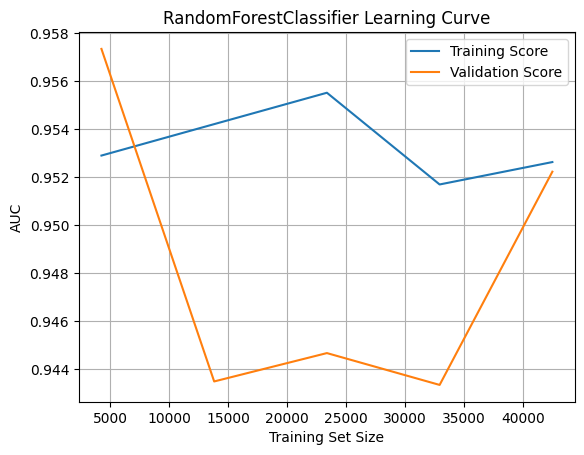

In [366]:
# Plotting to determine wether there is overfitting or underfitting
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, cv=kf, scoring='roc_auc', n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('AUC')
plt.title('RandomForestClassifier Learning Curve')
plt.legend()
plt.grid()
plt.show()

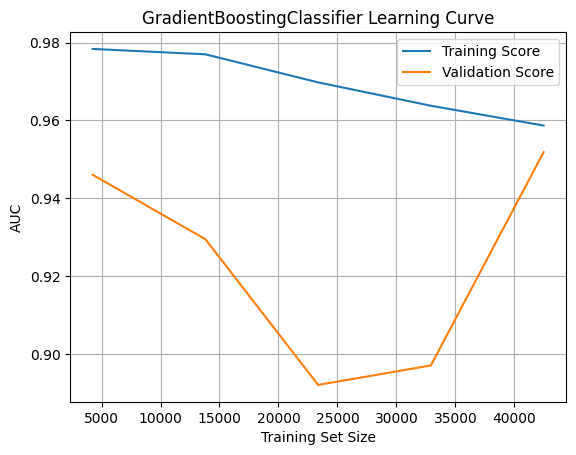

In [367]:
train_sizes, train_scores, test_scores = learning_curve(
    gb_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('AUC')
plt.title('GradientBoostingClassifier Learning Curve')
plt.legend()
plt.grid()
plt.show()

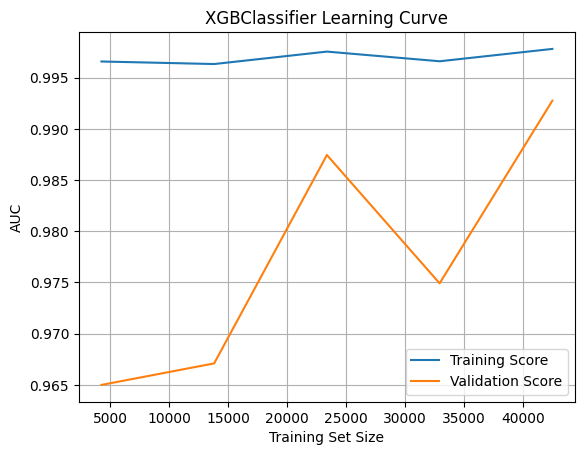

In [386]:
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1, error_score='raise')

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('AUC')
plt.title('XGBClassifier Learning Curve')
plt.legend()
plt.grid()
plt.show()

In [369]:

"""
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    lin_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('AUC')
plt.title('lin_model Learning Curve')
plt.legend()
plt.grid()
plt.show()
"""

"\nfrom sklearn.model_selection import learning_curve\n\ntrain_sizes, train_scores, test_scores = learning_curve(\n    lin_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)\n\ntrain_mean = np.mean(train_scores, axis=1)\ntest_mean = np.mean(test_scores, axis=1)\n\nplt.plot(train_sizes, train_mean, label='Training Score')\nplt.plot(train_sizes, test_mean, label='Validation Score')\nplt.xlabel('Training Set Size')\nplt.ylabel('AUC')\nplt.title('lin_model Learning Curve')\nplt.legend()\nplt.grid()\nplt.show()\n"

In [370]:
"""
importances = gb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [input_variables[i] for i in indices], rotation=90)
plt.title('GradientBoostingClassifier Feature Importance')
plt.show()
"""

'\nimportances = gb_model.feature_importances_\nindices = np.argsort(importances)[::-1]\n\nplt.bar(range(len(importances)), importances[indices], align="center")\nplt.xticks(range(len(importances)), [input_variables[i] for i in indices], rotation=90)\nplt.title(\'GradientBoostingClassifier Feature Importance\')\nplt.show()\n'

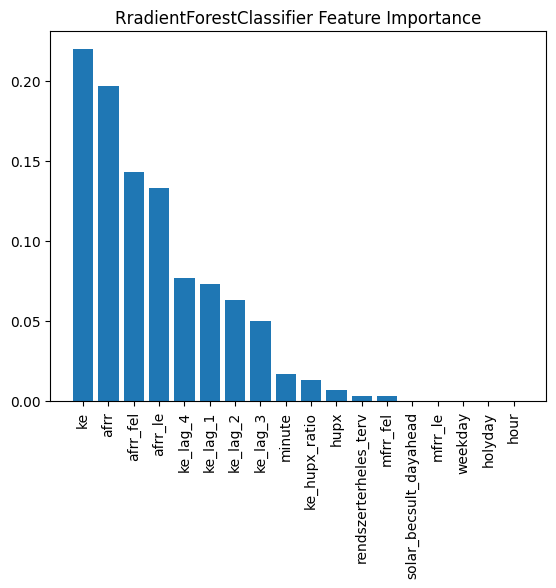

In [371]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [input_variables[i] for i in indices], rotation=90)
plt.title('RradientForestClassifier Feature Importance')
plt.show()

In [382]:
rf_predictions = rf_model.predict_proba(X_test)[:, 1]
gb_predictions = gb_model.predict_proba(X_test)[:, 1]
xgb_predictions = xgb_model.predict_proba(X_test)[:, 1]
# lin_predictions = lin_model.predict_proba(X_test)[:, 1]

rf_auc = roc_auc_score(y_test, rf_predictions)
gb_auc = roc_auc_score(y_test, gb_predictions)
xgb_auc = roc_auc_score(y_test, xgb_predictions)
# lin_uac = roc_auc_score(y_test, lin_predictions)

print(f"Random Forest AUC: {rf_auc}")
print(f"Gradient Boosting AUC: {gb_auc}")
print(f"XGB AUC: {xgb_auc}")
# print(f"Linear Regression AUC: {lin_uac}")

Random Forest AUC: 0.9497785220612347
XGB AUC: 0.9963884770103921


In [383]:
#ensemble_predictions = rf_predictions
ensemble_predictions = (rf_predictions + gb_predictions) / 2
# ensemble_predictions = gb_predictions 
ensemble_auc = roc_auc_score(y_test, ensemble_predictions)
print(f"Ensemble AUC: {ensemble_auc}")

Ensemble AUC: 0.9515306732043036


In [374]:
submit_df['prediction'] = ensemble_predictions
submit_df = submit_df[['rowID', 'prediction']]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22216\1166491766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit_df['prediction'] = ensemble_predictions


In [375]:
current_time = datetime.datetime.now()
time_string = current_time.strftime("%Y%m%d_%H%M%S")
filename = f"prediction_datas/ensemble_{time_string}.csv"
submit_df.to_csv(filename, index=False)

print(f"Submission saved to {filename}")

Submission saved to prediction_datas/ensemble_20241211_035455.csv
